In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import pandas
import seaborn
import pytry

This notebook gives a Nengo implementation of the Spiking Elementary Motion Detector (sEMD) from doi:10.1162/neco_a_01112

First, let's try to replicate Figure 2.  

In [45]:
# the facilitation spikes
def stim_1_func(t):
    index = int(t/0.001)
    if index in [100, 1100, 2100]:
        return 1000
    else:
        return 0
    
# the trigger spikes
def stim_2_func(t):
    index = int(t/0.001)
    if index in [90, 1500, 2150]:
        return 1000
    else:
        return 0

# the operation we're going to do on the two different inputs to the sEMD neuron
def dendrite_func(t, x):
    return x[0]*x[1]
    
# the trigger weight (w_e2 in the paper)
w = 2.0
    
model = nengo.Network()
with model:
    stim1 = nengo.Node(stim_1_func)
    stim2 = nengo.Node(stim_2_func)
    
    # this will handle the non-linearity we need for the input
    dendrite = nengo.Node(dendrite_func, size_in=2)
    
    # the facilitation input gets a low-pass filter of 10ms but the trigger is unfiltered
    nengo.Connection(stim1, dendrite[0], synapse=0.01)
    nengo.Connection(stim2, dendrite[1], transform=w, synapse=None)
    
    # one simple leaky integrate-and-fire neuron
    ens = nengo.Ensemble(n_neurons=1, dimensions=1, gain=np.ones(1), bias=np.zeros(1))
    # a low-pass filter of 5 ms for the output from the dendritic nonlinearity
    nengo.Connection(dendrite, ens.neurons, synapse=0.005)
    
    # now let's probe a bunch of data so we can plot things
    pd = nengo.Probe(dendrite, synapse=0.005)
    p1_n = nengo.Probe(stim1, synapse=None)
    p1 = nengo.Probe(stim1, synapse=0.01)
    p2 = nengo.Probe(stim2, synapse=None)
    
    pn = nengo.Probe(ens.neurons)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(3)
    

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Now let's re-create Figure 2

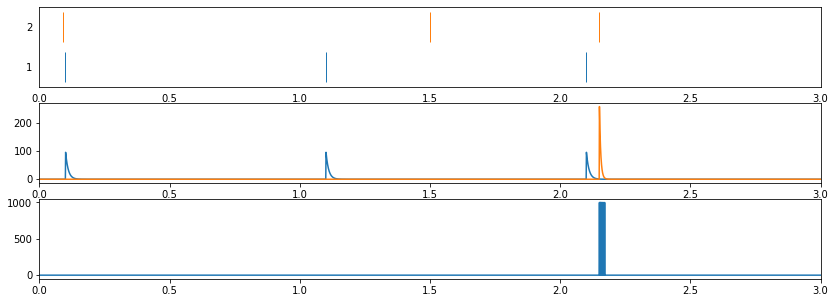

In [51]:
plt.figure(figsize=(14,5))
plt.subplot(3,1,1)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), np.hstack([sim.data[p1_n], sim.data[p2]]))
plt.xlim(0, sim.trange()[-1])
plt.ylim(0.5,2.5)

plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[p1])
plt.plot(sim.trange(), sim.data[pd])
plt.xlim(0, sim.trange()[-1])

plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[pn])
plt.xlim(0, sim.trange()[-1])
plt.show()

Now let's see what the performance is as we vary different parameters.  To do this, I'm using `pytry`, a simple Python package for running experiments and gathering data.  (You can install it with `pip install pytry`)

running SEMDTrial#20190706-135253-fa6bb205


c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


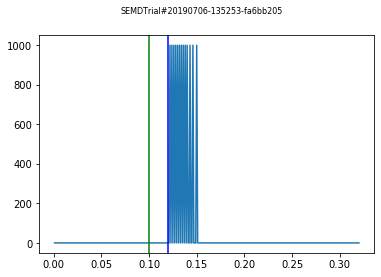

seed = 1
w_trig = 1.0
w_fac = 1.0
dt = 0.02
syn_fac = 0.01
syn_trig = 0.005
spike_count = 13.0


{'spike_count': 13.0}

In [55]:
import pytry
class SEMDTrial(pytry.PlotTrial):
    def params(self):
        self.param('trigger weight', w_trig=1.0)
        self.param('facilitation weight', w_fac=1.0)
        self.param('time delay between facilitation spike and trigger spike', dt=0)
        self.param('facilitation synapse', syn_fac=0.01)
        self.param('trigger synapse', syn_trig=0.005)
        
    
    def evaluate(self, p, plt):
        model = nengo.Network()
        with model:
            stim1 = nengo.Node(lambda t: 1000 if int(t/0.001)==100 else 0)
            stim2 = nengo.Node(lambda t: 1000 if int((t-p.dt)/0.001)==100 else 0)

            dendrite = nengo.Node(lambda t, x: x[0]*x[1], size_in=2)
            nengo.Connection(stim1, dendrite[0], transform=p.w_fac, synapse=p.syn_fac)
            nengo.Connection(stim2, dendrite[1], transform=p.w_trig, synapse=None)

            ens = nengo.Ensemble(n_neurons=1, dimensions=1, gain=np.ones(1), bias=np.zeros(1))
            nengo.Connection(dendrite, ens.neurons, synapse=p.syn_trig)

            pn = nengo.Probe(ens.neurons)        
            
        sim = nengo.Simulator(model, progress_bar=False)
        with sim:
            sim.run(0.1+p.dt+0.2)
            
        if plt:
            plt.plot(sim.trange(), sim.data[pn])   # neuron output
            plt.axvline(0.1, color='g')            # facilitation spike
            plt.axvline(0.1+p.dt, color='b')       # trigger spike
            
        spike_count = np.sum(sim.data[pn])/1000
        
        return dict(spike_count=spike_count)

SEMDTrial().run(plt=True, dt=0.02)

Now let's see how the spike count varies as we adjust `dt`.   We run the experiment varying `dt` and it will save data in a directory called `exp2`.

In [10]:
dts = (np.arange(99)+1)*0.001
for dt in dts:
    SEMDTrial().run(verbose=False, dt=dt, data_dir='exp2')

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


And we can now plot the data.

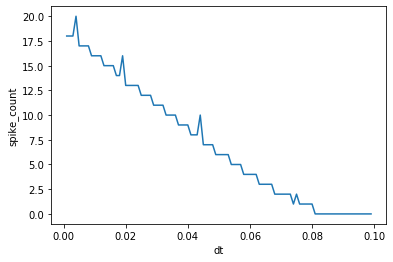

In [57]:
df = pandas.DataFrame(pytry.read('exp2'))
seaborn.lineplot('dt', 'spike_count', data=df)

That looks great!   Now let's try varying `w_fac` (the weight for the facilitation input).

In [31]:
dts = (np.arange(0,100,5)+1)*0.001
ws = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
for dt in dts:
    for w_fac in ws:
        SEMDTrial().run(verbose=False, dt=dt, w_fac=w_fac, data_dir='exp3')

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


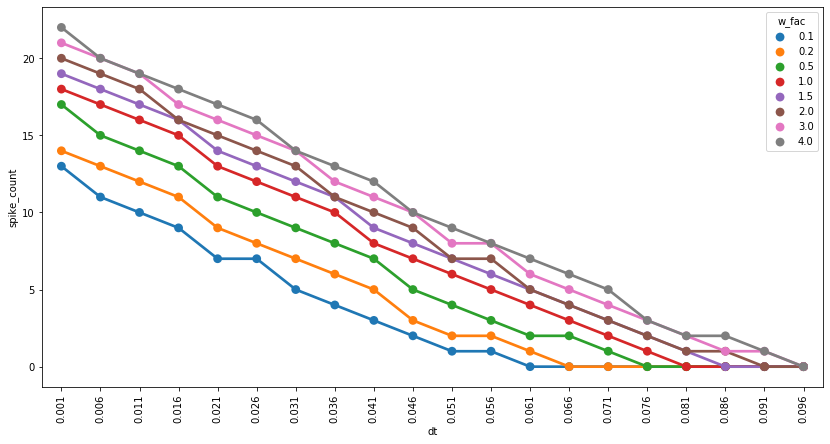

In [32]:
df = pandas.DataFrame(pytry.read('exp3'))
plt.figure(figsize=(14,7))
seaborn.pointplot('dt', 'spike_count', hue='w_fac', data=df)
plt.xticks(range(len(dts)), ['%g'%x for x in dts], rotation='vertical')
plt.show()

And let's also check varying `w_trig`.  This should give the identical results as varying `w_fac`, since they are just multiplied together.

In [33]:
dts = (np.arange(0,100,5)+1)*0.001
ws = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
for dt in dts:
    for w_trig in ws:
        SEMDTrial().run(verbose=False, dt=dt, w_trig=w_trig, data_dir='exp4')

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


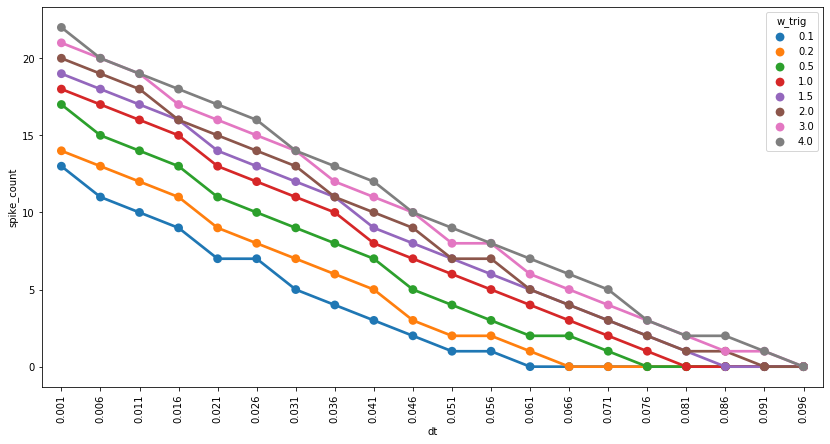

In [34]:
df = pandas.DataFrame(pytry.read('exp4'))
plt.figure(figsize=(14,7))
seaborn.pointplot('dt', 'spike_count', hue='w_trig', data=df)
plt.xticks(range(len(dts)), ['%g'%x for x in dts], rotation='vertical')
plt.show()

Now let's vary the time constant for the trigger synapse.

In [37]:
dts = (np.arange(0,100,5)+1)*0.001
syns = [0.001, 0.002, 0.005, 0.1, 0.2]
syns = [0.01, 0.02, 0.05]
for dt in dts:
    for syn_trig in syns:
        SEMDTrial().run(verbose=False, dt=dt, syn_trig=syn_trig, data_dir='exp5')

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


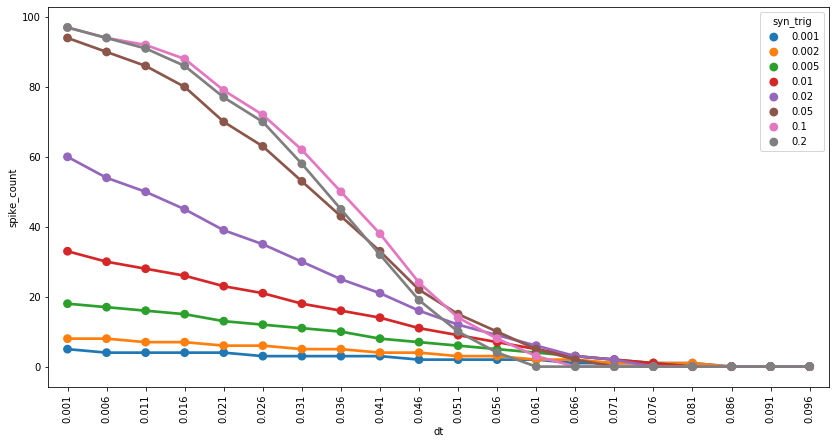

In [38]:
df = pandas.DataFrame(pytry.read('exp5'))
plt.figure(figsize=(14,7))
seaborn.pointplot('dt', 'spike_count', hue='syn_trig', data=df)
plt.xticks(range(len(dts)), ['%g'%x for x in dts], rotation='vertical')
plt.show()

And finally, let's very the time constant for the facilitation synapse.

In [39]:
dts = (np.arange(0,100,5)+1)*0.001
syns = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
for dt in dts:
    for syn_fac in syns:
        SEMDTrial().run(verbose=False, dt=dt, syn_fac=syn_fac, data_dir='exp6')

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


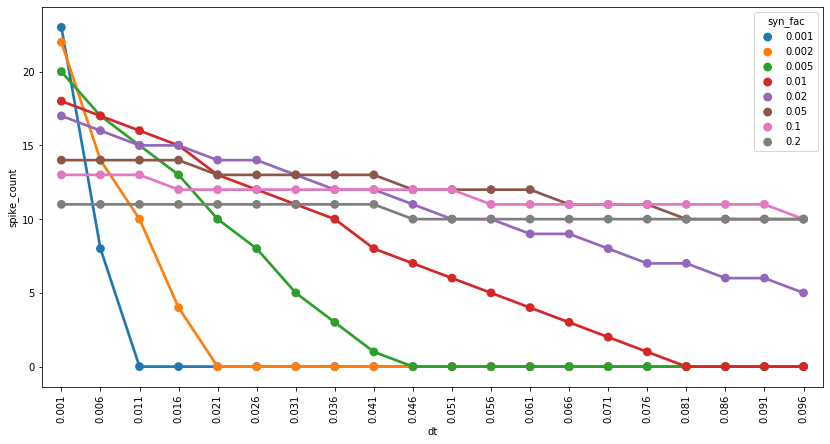

In [40]:
df = pandas.DataFrame(pytry.read('exp6'))
plt.figure(figsize=(14,7))
seaborn.pointplot('dt', 'spike_count', hue='syn_fac', data=df)
plt.xticks(range(len(dts)), ['%g'%x for x in dts], rotation='vertical')
plt.show()